## Wczytanie bibliotek

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
import scipy.signal as ss
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
import group_lasso
from sklearn.metrics import mean_squared_error
import os
import plotly.express as px
import plotly.graph_objects as go

## Ścieżka z modelami

In [2]:
ROOT = "C:/Users/ndzad/Dropbox/MINI/WTUM/Modele/"

## Wczytanie zbiorów

In [3]:
holidays_events = pd.read_csv("https://www.dropbox.com/s/bxyamlpevkiwwoq/holidays_events.csv?dl=1")
holidays_events["holiday_type"] = holidays_events["type"]
holidays_events.drop(["type"],axis=1,inplace=True)
oil = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1",parse_dates=['date'],index_col='date')
oil2 = pd.read_csv("https://www.dropbox.com/s/l6ln0ztl4m0pw3a/oil.csv?dl=1")
sample_submission = pd.read_csv("https://www.dropbox.com/s/68jjl61x6u3klos/sample_submission.csv?dl=1")
stores = pd.read_csv("https://www.dropbox.com/s/lcxn6r9bs2exguq/stores.csv?dl=1")
test = pd.read_csv("https://www.dropbox.com/s/cvdo1gn7r5lu2uz/test.csv?dl=1",index_col='id')
train = pd.read_csv("https://www.dropbox.com/s/s8p2b5awnuqfk0d/train.csv?dl=1",index_col='id')
transactions = pd.read_csv("https://www.dropbox.com/s/92fij9bcwt0e0cj/transactions.csv?dl=1")

c:\Users\ndzad\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Data Quality Check

In [4]:
import warnings
warnings.filterwarnings("ignore")

Zbiór holidays_events zawiera informacje o świętach.
date - data święta (od 2012-03-02 do 2017-12-26)
type - typ święta: Addition, Bridge, Event, Transfer, Holiday, Work Day
locale - Local, National, Regional
locale_name - nazwa jednostki administracyjnej odpowiedniej dla zmiennej 'locale'
description - opis święta
transferred - zmienna binarna, gdy święto zostało przesunięte na inny dzień

In [ ]:
holidays_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


Zbiór oil zawiera informacje o cenach ropy.
date - data raportu (od 2013-01-01 do 2017-08-31)
dcoilwtico - cena ropy w dolarach

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Zbiór sample_submission to zbiór techniczny

Zbiór stores zawiera informacje o sklepach:
store_nbr - id sklepu
city - miasto lokalizacji
state - stan
type - rodzaj sklepu: A, B, C, D, E
cluster - grupa podobnych sklepów

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Zbiór test zawiera informacje o zakupionych produktach:
1. id - id produktu
2. date - data sprzedaży (pierwsza data 15 dni od ostatniej daty ze zbioru train)
3. store_nbr - id sklepu
4. family - rodzaj zakupionej rzeczy
5. onpromotion - liczba produktów w danej 'family' na promocji w dnaym sklepie w danym sklepie

In [ ]:
test.head(10)

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
3000893,2017-08-16,1,BREAD/BAKERY,12
3000894,2017-08-16,1,CELEBRATION,0
3000895,2017-08-16,1,CLEANING,25
3000896,2017-08-16,1,DAIRY,45


Zbiór train zawiera informacje o zakupionych produktach:
1. id - id produktu
2. date - data sprzedaży
3. store_nbr - id sklepu
4. family - rodzaj zakupionej rzeczy
5. sales - liczba zakupionych produktów z danej 'family' w danym dniu i sklepie
6. onpromotion - liczba produktów w danej 'family' na promocji w danym dniu i sklepie

In [ ]:
train.tail(10)

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,2017-08-15,9,MEATS,449.228,0
3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000881,2017-08-15,9,PET SUPPLIES,6.000,0
3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Zbiór transactions zawiera informacje o liczbie transakcji w danym sklepie i dniu:
data - data
store_nbr - id sklepu
transactions - liczba transakcji

In [ ]:
transactions.head(10)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [ ]:
#Funkcja pomocniczna do rysowania wykresów
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, axiscolor ='black'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.gca().title.set_color(axiscolor)
    plt.gca().xaxis.label.set_color(axiscolor)
    plt.gca().yaxis.label.set_color(axiscolor)
    plt.tick_params(colors=axiscolor, which='both')
    plt.show()

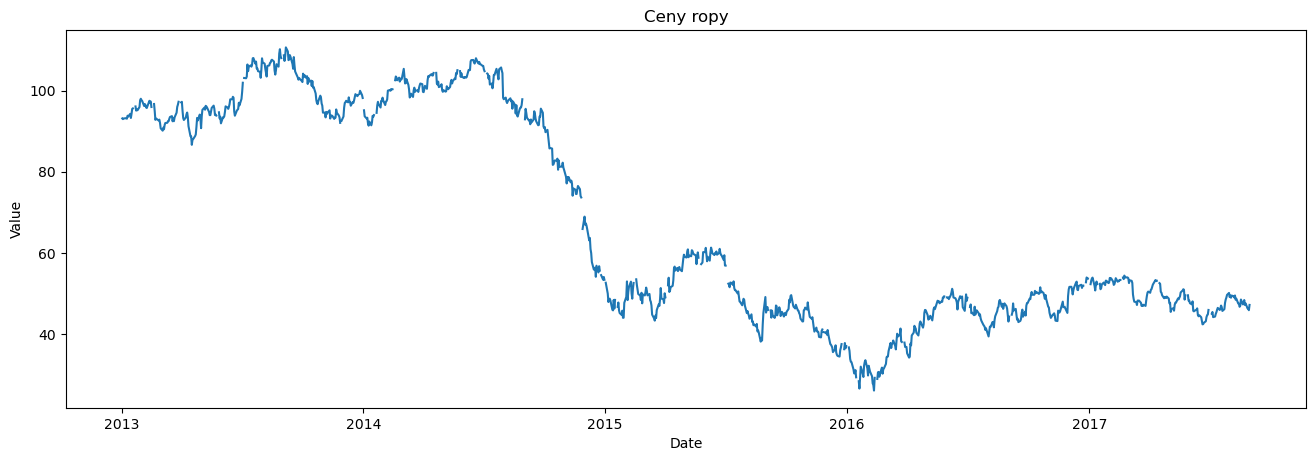

In [ ]:
plot_df(oil,x=oil.index, y=oil.dcoilwtico, title='Ceny ropy', axiscolor='black')

## Wizualizacja danych treningowych:

### 1. Wykres liczby sprzedanych artykułów w zależności od daty i w podziale na rodzaj artykułu

In [ ]:
fig = px.line(train, x='date', y='sales', color='family')
fig.show()

### 2. Wykres liczby sprzedanych artykułów w zależności od daty i w podziale na numer sklepu

In [ ]:
fig = px.line(train, x='date', y='sales', color='store_nbr')
fig.show()

## Funkcje pomocnicze

Funkcja przygotowująca dane objaśniające. Łączy zbiory i zmienia zmienne kategoryczne na zmienne numeryczna metodą One Hot Encoding, a także grupuje po dniu lub miesiącu.

In [5]:
def substraction(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3

In [6]:
def przygotowanie_danych(df: pd.DataFrame, type, type_item):
    """
    Funkcja łącząca zbiory i zmieniająca zmienne kategoryczne na zmienne numeryczne. Funkcja jest przewidziana
    df - zbiór danych treningowych
    type - dane sklepowe ('family') / dane rodzinne ('store_nbr')
    type_item - konretny element zmiennej type np. dla type=="family" type_item=="AUTOMOTIVE"
    """
    #Łaczymy z pozostałymi zbiorami

    #Zbiór stores
    df = df.merge(stores,how="left",left_on=['store_nbr'],right_on=['store_nbr'])

    #Zbiór transactions
    df = df.merge(transactions,how="left",left_on=['date','store_nbr'],right_on=['date','store_nbr'])

    #Zbiór holidays_events
    df = df.merge(holidays_events,how="left",left_on=['date'],right_on=['date'])

    #Dodanie oil
    df = df.merge(oil2,how="left",left_on=['date'],right_on=['date'])

    #Interpolacja braków danych z oil
    df.interpolate(method ='linear', limit_direction ='backward', inplace=True)

    #Wybieramy family ze zbioru traningowego
    df_fam = df.loc[(df[type]==type_item)]
    
    #Dodajemy zmienne na dzień tygodnia i na miesiąc
    df_fam['dayofweek'] = pd.DatetimeIndex(df_fam['date']).dayofweek + 1
    df_fam['month'] = pd.to_datetime(df_fam['date']).dt.month

    #Usunięcie zmiennych, które nie będą zmieniane
    df_fam.drop([type,"description","transferred"],axis=1,inplace=True)
    if type == "family":
        type_opposite = "store_nbr"
    elif type == "store_nbr":
        type_opposite = "family"

    #One Hot Encoding
    df_fam = pd.get_dummies(df_fam,columns=["locale",type_opposite,"city", "state", "type", "cluster","locale_name", "holiday_type"],prefix=["locale",type_opposite,"city", "state", "type", "cluster","locale_name", "holiday_type"])
    
    #W zbiorze test jest tylko jeden miesiąc dlatego musimy zrobić technicnzy zabieg polegający na dodaniu kolumn z samymi zerami.
    if 'sales' not in df_fam.columns:        
        missing_cols = substraction(przygotowanie_danych(train,type,type_item).columns,df_fam.columns)
        for i in missing_cols:
            df_fam[i] = 0

    return(df_fam)

In [7]:
def dane_drzewo(df: pd.DataFrame, type, type_item):
    df2 =df.copy()
    df2["family"], uniques=pd.factorize(df2["family"])
    df2["city"], uniques=pd.factorize(df2["city"])
    df2["state"], uniques=pd.factorize(df2["state"])
    df2["type"], uniques=pd.factorize(df2["type"])
    df2["locale"], uniques=pd.factorize(df2["locale"])
    df2["locale_name"], uniques=pd.factorize(df2["locale_name"])
    df2["holiday_type"], uniques=pd.factorize(df2["holiday_type"])
    df2.fillna(0,inplace=True)

Podział danych na część treningową i walidacyjną.

In [8]:
def podzial(df: pd.DataFrame, date='2016-06-01'):
    """
    Funkcja dzieli zbiór df na cześć treningową i walidacyjną względem date.
    """
    train = df.loc[(df['date']<date)].drop(["date"],axis=1)
    test = df.loc[(df['date']>=date)].reset_index(drop=True).drop(["date"],axis=1)
    return(train,test)

## Modele

### Model XGBoost

Idea metody polega na użyciu funkcjonalnej wersji algorytmu spadku gradientu.
Algorytm:
1. Krok $m=0: F(x) = \text{argmin}_{\eta}\sum_{i=1}^{n}L(y_i,\eta),$ gdzie $L(\cdot,\cdot)$ to funkcja straty.
2. Dla $m=1,\ldots,M:$
    1. Wyznacz pseudo rezidua: $r_{im}=-\nabla L(y_i,F_{m-1}(x_i)).$
    2. Dopasuj model (drzewo) $h_m$ dla danych $(x_i,r_{im})_{i=1}^{n}.$
    3. Oblicz $\eta_{m}=\text{argmin}_{\eta}\sum_{i=1}^{n}L(y_i,F_{m-1}(x_i)+\eta h_{m}(x_i)).$
    4. Wyznacz kolejny model:
        $F_m(x)=F_{m-1}(x)+\eta_{m} h_{m}(x).$
3. Ostateczny model: $F_{M}(x).$

W modelu stosujemy domyślne hiperparametry, czyli
* booster $=$ gbtree (rodzaj modelu w każdej iteracji)
* $\eta = 0.3$
* max_depth $= 6$
* min_child_weight $= 1$
* tree_method $=$ auto

In [9]:
def model_xgb(df1: pd.DataFrame,df2: pd.DataFrame, model_name: str):
    """
    Funkcja tworzy model XGBoost na danych df1 i waliduje na danych df2.
    """
    #Zbiory danych treningowy
    X = df1.drop(['sales'],axis=1).copy()
    Y = df1['sales'].copy()

    #Zbiory danych walidacyjnych 
    X_val = df2.drop(['sales'],axis=1)
    Y_val = df2['sales'].copy()

    #Dopasowanie modelu
    model = xgb.XGBRegressor()
    model.fit(X,Y)
    Y_pred = model.predict(X_val)

    #RMSE - jakość dopasowania
    RMSE = mean_squared_error(Y_val,Y_pred,squared=False)/(np.mean(Y_val))
    print("Model: ", model_name, " RMSE: ",RMSE)

    sciezka = ROOT + model_name + ".txt"
    model.save_model(sciezka)
    return(RMSE)

### Model regresji liniowej

$Y = X\beta + \varepsilon,$
<br />
gdzie $X$ jest macierzą zmiennych objaśniających, $\beta$ wektorem współczynników, a $\varepsilon$ wektorem błędów.
<br />
Przy pomocy metody najmniejszych kwadratów wyznaczamy $b_{MNK}$ tj. estymator $\beta$.
<br />
$b_{MNK} = (X^{T}X)^{-1}X^{T}Y$.

In [28]:
def model_ols(df1: pd.DataFrame,df2: pd.DataFrame, model_name: str):
    """
    Funkcja tworzy model regresji liniowej metodą najmniejszych kwadratów na danych df1 i waliduje na danych df2.
    """
    #Zbiory danych treningowy
    X = df1.drop(['sales'],axis=1).copy()
    Y = df1['sales'].copy()

    #Zbiory danych walidacyjnych 
    X_val = df2.drop(['sales'],axis=1)
    Y_val = df2['sales'].copy()

    #Dopasowanie modelu
    model = sm.OLS(Y,X).fit()
    
    Y_pred = model.predict(X_val)

    #RMSE - jakość dopasowania
    RMSE = mean_squared_error(Y_val,Y_pred,squared=False)/(np.mean(Y_val))
    print("Model: ", model_name, " RMSE: ",RMSE)

    return(RMSE)

### Model drzewa regresyjnego

Drzewo regresyjne polega na wykonywaniu testu w każdym węźle, aby podzielić dane na dwie grupy.

Algorytm:
1. Proces zaczynamy w korzeniu.
2. W każdym węźle ykonujemy test, czyli wybieramy zmienną $x_j \in \{ x_1,\dots, x_p\}$
oraz próg $t$ lub podzbiór $\{ a1,\dots,a_k\},$ który maksymalizuje $\Delta$ SSE $=$ $\text{SSE}_P - \frac{n_{L}}{n_{P}} \text{SSE}_L - \frac{n_R}{n_P} \text{SSE}_R,$
<br />
gdzie $P, L, R$ to oznaczenia węzłów PARENT, LEFT, RIGHT, $n_P, n_L, n_R$ to ich odpowiednie liczności, $SSE_P, SSE_L, SSE_P$ to ich odpowiednie SSE.
3. Jeśli warunek w węźle jest spełniony, to przesuwamy się do lewego poddrzewa, a pozostałe obserwacje do prawego poddrzewa.
4. Predykcja dla danej obserwacji $x_o$ to średnia zmiennej $y$ w węźle, który odpowiada $x_0$.

In [29]:
def model_tree(df1: pd.DataFrame,df2: pd.DataFrame, model_name: str):
    """
    Funkcja tworzy model drzewa regresyjnego na danych df1 i waliduje na danych df2.
    """
    #Zbiory danych treningowy
    X = df1.drop(['sales'],axis=1).copy()
    Y = df1['sales'].copy()

    #Zbiory danych walidacyjnych 
    X_val = df2.drop(['sales'],axis=1)
    Y_val = df2['sales'].copy()

    #Dopasowanie modelu
    model = DecisionTreeRegressor().fit(X,Y)
    Y_pred = model.predict(X_val)

    #RMSE - jakość dopasowania
    RMSE = mean_squared_error(Y_val,Y_pred,squared=False)/(np.mean(Y_val))
    print("Model: ", model_name, " RMSE: ",RMSE)

    return(RMSE)

### Model lassa grupowego

Główną ideą grupowego Lasso jest rozwiązanie poniższego problemu

$$\hat{\beta} = \argmin_{\beta} \left( \sum_{i=1}^n l \left( f \left( \beta, x_i \right), y_i \right)  + \lambda \sum_{j=1}^{G} \sqrt{|j|} \cdot ||\beta \left( j \right)||_2 \right), $$

gdzie $\beta \left( j \right)$ jest wektorem współczynników odpowiadających $j-\text{tej}$ grupie, $\lambda>0$ parametrem odpowiadającym za wielkość kary, natomiast $|j|$ oznacza rozmiar $j-\text{tej}$ grupy.

Grupy są naturalnie wyznaczone przez zmienne z OneHotEncoding np. dni tygodnia są w jednej grupie.

In [43]:
def model_group_lasso(df1,df2, model_name: str):
    """
    Funkcja tworzy model grupowego lasso na danych df1 i waliduje na danych df2.
    """
    #Zbiory danych treningowy
    X = df1.drop(['sales'],axis=1).copy()
    Y = df1['sales'].copy()

    #Zbiory danych walidacyjnych 
    X_val = df2.drop(['sales'],axis=1)
    Y_val = df2['sales'].copy()

    #Grupy
    if len(df1.columns) == 153:
        grupy = [-1	,-1	,-1	,-1	,-1	,1	,1	,1	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,3	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,4	,5	,5	,5	,5	,5	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,6	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,8	,8	,8	,8	,8	,8]
    elif len(df1.columns) == 76:
        grupy = [-1	,-1	,-1	,-1	,-1	,1	,1	,1	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,2	,3	,4	,5	,6	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,7	,8	,8	,8	,8	,8	,8]

    #Dopasowanie modelu
    model = group_lasso.GroupLasso(groups=grupy).fit(X,Y)
    Y_pred = model.predict(X_val)

    #RMSE - jakość dopasowania
    RMSE = mean_squared_error(Y_val,Y_pred,squared=False)/(np.mean(Y_val))
    print("Model: ", model_name, " RMSE: ",RMSE)

    return(RMSE)

## Funkcja do predykcji

In [13]:
def predykcja (df: pd.DataFrame, model: xgb.XGBRegressor, folder: str):
    """
    Funkcja wykonuje predykcje modelu model na zbiorze df i odpisuje w formacie .csv do folderu folder.
    """
    mod2 = xgb.XGBRegressor()
    mod2.load_model(ROOT+model+".txt")
    df_res =df.copy()
    pred = mod2.predict(df)
    df_res["sales_pred"] = pred
    pred_csv = df_res.to_csv(folder+model+".csv",index=False)

    return(pred_csv)

## Przykłady

### Zbiory dla przykładów.

In [14]:
(train2,test2) = podzial(przygotowanie_danych(train,'family','AUTOMOTIVE'),'2016-06-01')

In [16]:
(train3,test3) = podzial(przygotowanie_danych(train,'store_nbr',1),'2016-06-01')

### XGBoost - przykłady

In [15]:
RMSE_xgb = model_xgb(train2,test2,"przykladowa_rodzina")

Model:  przykladowa_rodzina  RMSE:  0.6861653699517859


In [17]:
RMSE_xgb = model_xgb(train3,test3,"przykladowy_sklep")

Model:  przykladowy_sklep  RMSE:  0.6198961685176666


### OLS - przykłady

In [31]:
RMSE_ols = model_ols(train2,test2,"przykladowa_rodzina")

Model:  przykladowa_rodzina  RMSE:  0.55467843815865


In [32]:
RMSE_ols = model_ols(train3,test3,"przykladowy_sklep")

Model:  przykladowy_sklep  RMSE:  1.6345695406293494


### Drzewa regresyjnego - przykłady

In [33]:
RMSE_tree = model_tree(train2,test2,"przykladowa_rodzina")

Model:  przykladowa_rodzina  RMSE:  0.5957776758879871


In [34]:
RMSE_tree = model_tree(train3,test3,"przykladowy_sklep")

Model:  przykladowy_sklep  RMSE:  2.0635414972567943


### Grupowe Lasso - przykłady

In [44]:
RMSE_group_lasso = model_group_lasso(train2,test2,"przykladowa_rodzina")

Model:  przykladowa_rodzina  RMSE:  1.327302825425444


In [45]:
RMSE_group_lasso = model_group_lasso(train3,test3,"przykladowy_sklep")

Model:  przykladowy_sklep  RMSE:  2.296909491056904


Dla przykładowego sklepu i dla przykładowej rodziny produktów RMSE wychodzi najlepsze dla modelu XGBoost. W związku z tym tworzymy modele XGBoost dla każdego sklepu i dla każdej rodziny, a następnie predykcje na zbiorze test.

## Model dla każdej rodziny. 

Modele odpisywane są do ROOT - ścieżki podanej na początku.

In [18]:
families = np.array(train["family"].unique())
family_RMSEs = []

In [19]:
for i in families:
    (train2,test2) = podzial(przygotowanie_danych(train,'family',i),'2016-06-01')
    RMSE_xgb = model_xgb(train2,test2,i)
    family_RMSEs.append(RMSE_xgb)

Model:  AUTOMOTIVE  RMSE:  0.6861653699517859
Model:  BABY CARE  RMSE:  3.4948295658920756
Model:  BEAUTY  RMSE:  0.7205881764239868
Model:  BEVERAGES  RMSE:  0.31779410053589807
Model:  BOOKS  RMSE:  3.994430513647246
Model:  BREAD_BAKERY  RMSE:  0.2647430624584262
Model:  CELEBRATION  RMSE:  1.170489191002666
Model:  CLEANING  RMSE:  0.30010944377920146
Model:  DAIRY  RMSE:  0.22848451644533507
Model:  DELI  RMSE:  0.25711408962040094
Model:  EGGS  RMSE:  0.5358559262506273
Model:  FROZEN FOODS  RMSE:  1.183994333148742
Model:  GROCERY I  RMSE:  0.34631785551534033
Model:  GROCERY II  RMSE:  0.8921728224904292
Model:  HARDWARE  RMSE:  1.2474795856009246
Model:  HOME AND KITCHEN I  RMSE:  1.2312579643318984
Model:  HOME AND KITCHEN II  RMSE:  1.395166723816384
Model:  HOME APPLIANCES  RMSE:  2.027397594974563
Model:  HOME CARE  RMSE:  0.3832039660347386
Model:  LADIESWEAR  RMSE:  1.0003645281008315
Model:  LAWN AND GARDEN  RMSE:  1.5703395588668807
Model:  LINGERIE  RMSE:  1.611733919

## Predykcja dla każdej rodziny.

 Predykcja odpisywana jest do ROOT - ścieżki podanej na początku.

In [20]:
time = dt.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
folder2 = ROOT+"predict_family_"+time+"/"
os.makedirs(folder2)

In [21]:
mod2 = xgb.XGBRegressor()
for i in families:
    t = przygotowanie_danych(test,"family",i)
    t.drop(["date","sales"],axis=1,inplace=True)
    mod2.load_model(ROOT+i+".txt")
    mod2.predict(test2.drop(["sales"],axis=1))
    predykcja(t,i,folder2)

## Model dla każdego sklepu.

 Modele odpisywane są do ROOT - ścieżki podanej na początku.

In [23]:
stores_nbr = np.array(train["store_nbr"].unique())
stores_nbr.sort()
stores_nbr_RMSEs = []

In [46]:
for i in stores_nbr:
    (train3,test3) = podzial(przygotowanie_danych(train,'store_nbr',i),'2016-06-01')
    RMSE_xgb = model_xgb(train3,test3,str(i))
    stores_nbr_RMSEs.append(RMSE_xgb)

Model:  1  RMSE:  0.6198961685176666
Model:  2  RMSE:  1.2022746613558344
Model:  3  RMSE:  0.6386473097009742
Model:  4  RMSE:  0.6145011981779533
Model:  5  RMSE:  0.47481874747601677
Model:  6  RMSE:  0.5299957297301355
Model:  7  RMSE:  0.6251099201534559
Model:  8  RMSE:  0.5682544798027046
Model:  9  RMSE:  0.7249683913445258
Model:  10  RMSE:  0.6463020048718221
Model:  11  RMSE:  0.5876590283466362
Model:  12  RMSE:  0.6673139636253224
Model:  13  RMSE:  0.6578999813581597
Model:  14  RMSE:  0.8180761879968397
Model:  15  RMSE:  0.6871555087511951
Model:  16  RMSE:  0.9739440071073853


KeyboardInterrupt: 

## Predykcja dla każdego sklepu.

 Predykcje odpisywane są do ROOT - ścieżki podanej na początku.

In [ ]:
t = przygotowanie_danych(test,"family","AUTOMOTIVE")
t.drop(["date","sales"],axis=1,inplace=True)
time = dt.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
folder2 = ROOT+"predict_store_nbr_"+time+"/"
os.makedirs(folder2)

KeyboardInterrupt: 

In [ ]:
mod2 = xgb.XGBRegressor()
for i in stores_nbr:
    mod2.load_model(ROOT+i+".txt")
    mod2.predict(test2.drop(["sales"],axis=1))
    predykcja(t,i,folder2)

## Wykres predykcji wraz z oryginalnymi danymi.

In [ ]:
def wykres(family: str, type: int):
    """
    @param family: kategoria dla której chcemy narysować wykres
    @param type: typ wykresu 1 - zwykły szereg czasowy; 2 - szereg czasowy z suwakiem; 3 - szereg czasowy z suwakiem i przyciskami
    
    """
    if type not in [1,2,3]:
        raise Exception("Podano błędny numer typu wykresu!")
    t = przygotowanie_danych(test,"family",family)
    t = t.drop(["sales"],axis=1)
    temp = []
    for i in range(1,55):
        temp.append('store_nbr_'+str(i))
    df = pd.read_csv("predict_2022_05_18-22-13-14/"+family+".csv")
    df['store_nbr'] =df.loc[:,temp].idxmax(1)
    df['date'] = t['date'].reset_index(drop=True)
    df['store_nbr'] =df['store_nbr'].str[10:].astype(int)
    df = df.rename(columns={'sales_pred':'sales'})
    df = df[['sales','store_nbr','date']]
    train_df = train.loc[(train['family'] == family)]
    train_df = train_df[['sales','store_nbr','date']].reset_index()
    df_concat = pd.concat([train_df,df], axis=0).drop(['id'],axis=1)
    df_concat = df_concat.groupby(['date'])['sales'].mean().to_frame()
    df_concat = df_concat.reset_index()
    if type == 1:
        fig = px.line(df_concat, x='date', y='sales', title = "Sprzedaż dla kategorii "+family)
        fig.show()
    elif type == 2:
        fig = px.line(df_concat, x='date', y='sales')
        fig.update_xaxes(rangeslider_visible=True)
        fig.show()
    else:
        fig = px.line(df_concat, x='date', y='sales')
        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            )
        )
        fig.show()
    

In [ ]:
wykres('BABY CARE',3)